# Quantitative Momentum Strategy
"Momentum investing" means investing in the stocks that have increased in price the most.

In this project, I have built an investing strategy that selects the 10 stocks with the highest price momentum in the Nifty 50 index. From there, we will calculate recommended trades for an equal-weight portfolio of these 10 stocks.

# Library Imports
The first step is to import the open-source software libraries


In [1]:
import yfinance as yf# The yahoo finance api
import numpy as np #The Numpy numerical computing library
import pandas as pd #The Pandas data science library
import requests #The requests library for HTTP requests in Python
import xlsxwriter #The XlsxWriter libarary for 
import math #The Python math module
from scipy import stats #The SciPy stats module
from datetime import date

# Today's date
For this project I will be using historical data to make recommended trades(present day), which is why obtaining today's date would serve useful.

In [2]:
today = str(date.today())
today

'2021-08-23'

The following lines of code are to obtain the date of 2 months ago

In [3]:
year=today[:4]
month=int(today[5]+today[6])-2
day=today[8]+today[9]
if (month<10):
    month="0"+str(month)

if(month==1):
    year=int(year)-1
    month=11
if(month==0):
    year=int(year)-1
    month=12
    
two_months_ago= year+"-"+month+"-"+day
two_months_ago

'2021-06-23'

# Obtaining historical data
The following line of code is the method used to obtain historical data on a specific stock from the yahoo finance API.

In [4]:
df = yf.download('TATAMOTORS.NS', 
                  start=two_months_ago, 
                  end=today, 
                  progress=False,
                )
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-06-23,341.000000,343.250000,334.299988,335.250000,335.250000,25741628
2021-06-24,335.000000,337.399994,333.350006,334.649994,334.649994,15580223
2021-06-25,335.899994,342.799988,335.899994,339.649994,339.649994,22426352
2021-06-28,340.799988,345.000000,337.549988,342.799988,342.799988,17843975
2021-06-29,342.649994,346.500000,339.600006,341.549988,341.549988,22462297



The obtained DataFrame has been used to calculate the required parameters to make recommended trades.

Parameters:
    
    1)Three Day Change(%)
    
    2)One Week Change(%)
    
    3)One Month Change(%)
    

In [5]:
df['Open_1'] = df['Open'].shift(3)
df['Three_day_change(%)'] = ((df['Open'] - df['Open_1'])/df['Open_1'])*100
df= df.drop('Open_1', axis=1)
df['Open_1'] = df['Open'].shift(7)
df['1week_change(%)'] = ((df['Open'] - df['Open_1'])/df['Open_1'])*100
df= df.drop('Open_1', axis=1)
df['Open_1'] = df['Open'].shift(22)
df['1month_change(%)'] = ((df['Open'] - df['Open_1'])/df['Open_1'])*100
df= df.drop('Open_1', axis=1)
df = df.iloc[::-1]

df.head()

,Open,High,Low,Close,Adj Close,Volume,Three_day_change(%),1week_change(%),1month_change(%)
Date,,,,,,,,,
2021-08-20,289.500000,290.700012,281.000000,283.100006,283.100006,32578752,-5.376699,-2.819736,-6.295521
2021-08-18,296.899994,297.750000,292.600006,293.350006,293.350006,18004320,-3.853625,-1.280135,-4.564453
2021-08-17,302.799988,302.799988,292.799988,297.700012,297.700012,25539214,1.849983,0.916514,-2.479875
2021-08-16,305.950012,307.850006,303.049988,303.700012,303.700012,14348786,3.606510,3.536383,-1.306448
2021-08-13,308.799988,311.500000,303.049988,307.250000,307.250000,34922863,3.658944,1.328954,-0.387101


# Building the DataFrame for every stock

Repeating the method used above to obtain our parameters on every stock in Nifty 50 we obtain the following DataFrame.

In [6]:
hqm_columns = [
                'Ticker', 
                'Open Price',
                'Closed Price',
                'Number of Shares to Buy', 
                '3-day Price Return', 
                '1-week Price Return',
                '1-Month Price Return',
                'HQM Score'
                ]

hqm_dataframe = pd.DataFrame(columns = hqm_columns)
hqm_dataframe


,Ticker,Open Price,Closed Price,Number of Shares to Buy,3-day Price Return,1-week Price Return,1-Month Price Return,HQM Score


In [7]:
stocks= pd.read_csv('NIFTY_50_STOCKS.csv')
for stock in stocks['Symbol']:
    stock=stock+".NS"
    df = yf.download(stock, 
                  start=two_months_ago, 
                  end=today, 
                  progress=False,)
    df['Open_1'] = df['Open'].shift(3)
    df['Three_day_change(%)'] = ((df['Open'] - df['Open_1'])/df['Open_1'])*100
    df= df.drop('Open_1', axis=1)
    df['Open_1'] = df['Open'].shift(7)
    df['1week_change(%)'] = ((df['Open'] - df['Open_1'])/df['Open_1'])*100
    df= df.drop('Open_1', axis=1)
    df['Open_1'] = df['Open'].shift(22)
    df['1month_change(%)'] = ((df['Open'] - df['Open_1'])/df['Open_1'])*100
    df= df.drop('Open_1', axis=1)
    df = df.iloc[::-1]
    Three_day_change=df['Three_day_change(%)'][0]
    one_week_change=df['1week_change(%)'][0]
    one_month_change=df['1month_change(%)'][0]
    
    hqm_dataframe = hqm_dataframe.append(
                                        pd.Series([stock, 
                                                   df['Open'][0],
                                                   df['Close'][0],
                                                   'N/A',
                                                   df['Three_day_change(%)'][0],
                                                   df['1week_change(%)'][0],
                                                   df['1month_change(%)'][0],
                                                   'N/A'
                                                   ], 
                                                  index = hqm_columns), 
                                        ignore_index = True)
        

        
        
        
hqm_dataframe
    

    

    
    
    
    
    

,Ticker,Open Price,Closed Price,Number of Shares to Buy,3-day Price Return,1-week Price Return,1-Month Price Return,HQM Score
0,TATASTEEL.NS,1445.050049,1375.599976,N/A,-2.624660,2.340655,14.777605,N/A
1,BAJFINANCE.NS,6471.950195,6661.100098,N/A,5.252077,3.967071,6.306672,N/A
2,M&M.NS,788.799988,785.650024,N/A,1.076366,1.525192,1.675690,N/A
3,BRITANNIA.NS,3640.000000,3895.949951,N/A,1.960784,0.107255,5.801654,N/A
4,IOC.NS,105.449997,103.500000,N/A,0.668255,0.524304,-0.283691,N/A
5,BPCL.NS,461.799988,455.200012,N/A,0.719736,1.606158,3.542598,N/A
6,JSWSTEEL.NS,722.000000,684.599976,N/A,-3.087248,-3.591938,3.586801,N/A
7,BAJAJFINSV.NS,14856.349609,14978.549805,N/A,3.771543,4.108967,17.163640,N/A
8,RELIANCE.NS,2143.000000,2148.250000,N/A,-0.295443,2.929875,2.047619,N/A
9,HDFC.NS,2700.000000,2722.050049,N/A,0.118657,2.478462,8.520900,N/A


# Calculating HQM Score(Momentum score) 
This is done by taking mean of :

    1)Three Day Change(%)
    
    2)One Week Change(%)
    
    3)One Month Change(%)

In [8]:
from statistics import mean

for row in hqm_dataframe.index:
    momentum_percentiles = []
    momentum_percentiles.append(hqm_dataframe.loc[row, '3-day Price Return'])
    momentum_percentiles.append(hqm_dataframe.loc[row, '1-week Price Return'])
    momentum_percentiles.append(hqm_dataframe.loc[row, '1-Month Price Return'])
    hqm_dataframe.loc[row, 'HQM Score'] = mean(momentum_percentiles)
hqm_dataframe

,Ticker,Open Price,Closed Price,Number of Shares to Buy,3-day Price Return,1-week Price Return,1-Month Price Return,HQM Score
0,TATASTEEL.NS,1445.050049,1375.599976,N/A,-2.624660,2.340655,14.777605,4.8312
1,BAJFINANCE.NS,6471.950195,6661.100098,N/A,5.252077,3.967071,6.306672,5.17527
2,M&M.NS,788.799988,785.650024,N/A,1.076366,1.525192,1.675690,1.42575
3,BRITANNIA.NS,3640.000000,3895.949951,N/A,1.960784,0.107255,5.801654,2.62323
4,IOC.NS,105.449997,103.500000,N/A,0.668255,0.524304,-0.283691,0.302956
5,BPCL.NS,461.799988,455.200012,N/A,0.719736,1.606158,3.542598,1.95616
6,JSWSTEEL.NS,722.000000,684.599976,N/A,-3.087248,-3.591938,3.586801,-1.0308
7,BAJAJFINSV.NS,14856.349609,14978.549805,N/A,3.771543,4.108967,17.163640,8.34805
8,RELIANCE.NS,2143.000000,2148.250000,N/A,-0.295443,2.929875,2.047619,1.56068
9,HDFC.NS,2700.000000,2722.050049,N/A,0.118657,2.478462,8.520900,3.70601


# Picking the top 10 Momentum Stocks

In [9]:
hqm_dataframe=hqm_dataframe.sort_values(by = 'HQM Score', ascending = False)
hqm_dataframe = hqm_dataframe[:10]
hqm_dataframe.reset_index(inplace = True)
hqm_dataframe.drop('index', axis=1, inplace = True)
hqm_dataframe

,Ticker,Open Price,Closed Price,Number of Shares to Buy,3-day Price Return,1-week Price Return,1-Month Price Return,HQM Score
0,TECHM.NS,1370.650024,1399.199951,N/A,-0.817680,6.416927,25.978863,10.526
1,BAJAJFINSV.NS,14856.349609,14978.549805,N/A,3.771543,4.108967,17.163640,8.34805
2,TATACONSUM.NS,832.950012,847.299988,N/A,3.164477,8.754405,9.454667,7.12452
3,TCS.NS,3506.000000,3559.500000,N/A,1.329480,5.742547,10.251572,5.77453
4,BAJFINANCE.NS,6471.950195,6661.100098,N/A,5.252077,3.967071,6.306672,5.17527
5,BHARTIARTL.NS,619.500000,613.700012,N/A,-3.013699,2.872798,14.935065,4.93139
6,TATASTEEL.NS,1445.050049,1375.599976,N/A,-2.624660,2.340655,14.777605,4.8312
7,INFY.NS,1716.099976,1732.949951,N/A,0.491891,2.883692,11.096008,4.82386
8,HCLTECH.NS,1107.500000,1117.349976,N/A,-1.199871,5.225653,10.199005,4.7416
9,TITAN.NS,1859.400024,1876.800049,N/A,1.717726,2.729283,9.741202,4.7294


# Calculating the Number of Shares to Buy
An equal weight portfolio of the top 10 Momentum Stocks will be created.

In [10]:
portfolio_size = input("Enter the value of your portfolio:")

try:
    val = float(portfolio_size)
except ValueError:
    print("That's not a number! \n Try again:")
    portfolio_size = input("Enter the value of your portfolio:")


Enter the value of your portfolio:1000000


In [11]:
position_size = float(portfolio_size) / len(hqm_dataframe.index)
for i in range(0, len(hqm_dataframe['Ticker'])):
    hqm_dataframe.loc[i, 'Number of Shares to Buy'] = math.floor(position_size / hqm_dataframe['Open Price'][i])
hqm_dataframe

,Ticker,Open Price,Closed Price,Number of Shares to Buy,3-day Price Return,1-week Price Return,1-Month Price Return,HQM Score
0,TECHM.NS,1370.650024,1399.199951,72,-0.817680,6.416927,25.978863,10.526
1,BAJAJFINSV.NS,14856.349609,14978.549805,6,3.771543,4.108967,17.163640,8.34805
2,TATACONSUM.NS,832.950012,847.299988,120,3.164477,8.754405,9.454667,7.12452
3,TCS.NS,3506.000000,3559.500000,28,1.329480,5.742547,10.251572,5.77453
4,BAJFINANCE.NS,6471.950195,6661.100098,15,5.252077,3.967071,6.306672,5.17527
5,BHARTIARTL.NS,619.500000,613.700012,161,-3.013699,2.872798,14.935065,4.93139
6,TATASTEEL.NS,1445.050049,1375.599976,69,-2.624660,2.340655,14.777605,4.8312
7,INFY.NS,1716.099976,1732.949951,58,0.491891,2.883692,11.096008,4.82386
8,HCLTECH.NS,1107.500000,1117.349976,90,-1.199871,5.225653,10.199005,4.7416
9,TITAN.NS,1859.400024,1876.800049,53,1.717726,2.729283,9.741202,4.7294


In [12]:
for row in hqm_dataframe.index:
    hqm_dataframe.loc[row, '3-day Price Return']=hqm_dataframe.loc[row, '3-day Price Return']/100
    hqm_dataframe.loc[row, '1-week Price Return']=hqm_dataframe.loc[row, '1-week Price Return']/100
    hqm_dataframe.loc[row, '1-Month Price Return']=hqm_dataframe.loc[row, '1-Month Price Return']/100

# Calculating Average True Range

In this step, I have calculated the Average True Range(%) for each stock above( over a 1 week period ).

In [13]:
hqm_dataframe['ATR%']=0.0
atrlist=[]
row=0
for stock in hqm_dataframe['Ticker']:
    df = yf.download(stock, 
                  start=two_months_ago, 
                  end=today, 
                  progress=False)
    max=0.0
    min=10000000
    for i in df['High'][7:]:
        if(i>max):
            max=i
    for i in df['Low'][7:]:
        if(i<min):
            min=i
    
    atr=(max-min)/df['Open'][-1]
    atr=atr*100
    
    hqm_dataframe.loc[row, 'ATR%'] = atr
    
    row+=1

hqm_dataframe
        
        
    
    

,Ticker,Open Price,Closed Price,Number of Shares to Buy,3-day Price Return,1-week Price Return,1-Month Price Return,HQM Score,ATR%
0,TECHM.NS,1370.650024,1399.199951,72,-0.008177,0.064169,0.259789,10.526,29.088394
1,BAJAJFINSV.NS,14856.349609,14978.549805,6,0.037715,0.041090,0.171636,8.34805,24.144558
2,TATACONSUM.NS,832.950012,847.299988,120,0.031645,0.087544,0.094547,7.12452,13.590253
3,TCS.NS,3506.000000,3559.500000,28,0.013295,0.057425,0.102516,5.77453,13.194526
4,BAJFINANCE.NS,6471.950195,6661.100098,15,0.052521,0.039671,0.063067,5.17527,13.360736
5,BHARTIARTL.NS,619.500000,613.700012,161,-0.030137,0.028728,0.149351,4.93139,20.016142
6,TATASTEEL.NS,1445.050049,1375.599976,69,-0.026247,0.023407,0.147776,4.8312,27.978273
7,INFY.NS,1716.099976,1732.949951,58,0.004919,0.028837,0.110960,4.82386,12.921741
8,HCLTECH.NS,1107.500000,1117.349976,90,-0.011999,0.052257,0.101990,4.7416,17.841990
9,TITAN.NS,1859.400024,1876.800049,53,0.017177,0.027293,0.097412,4.7294,12.358828


# Volatility Heat Map

Volatility is determined form the ATR% of each stock.
Higher the ATR%, higher the Volatility

A Volatility Heat Map is created to visualize the Volatility of each stock. 

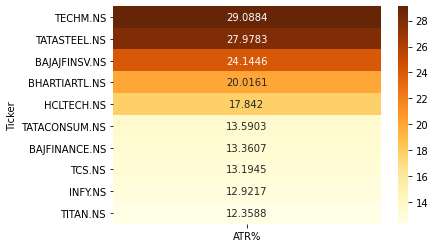

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
array=[]
for x in hqm_dataframe['ATR%']:
    array.append(x)
hqm_dataframe= hqm_dataframe.drop('ATR%', axis=1)
hqm_dataframe= hqm_dataframe.drop('Closed Price', axis=1)
    
v_dataframe=pd.DataFrame({"ATR%": array} ,index= hqm_dataframe['Ticker'])
v_dataframe=v_dataframe.sort_values(by = 'ATR%', ascending = False)
sns.heatmap(v_dataframe, annot=True, fmt="g", cmap='YlOrBr')

plt.show()


# Formatting Excel Output
I will be using the XlsxWriter library for Python to create nicely-formatted Excel files.

In [15]:
writer = pd.ExcelWriter('momentum_strategy.xlsx', engine='xlsxwriter')
hqm_dataframe.to_excel(writer, sheet_name='Momentum Strategy', index = False)

# Creating the formats needed for the .xlsx file

In [16]:
background_color = '#0a0a23'
font_color = '#ffffff'

string_template = writer.book.add_format(
        {
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

dollar_template = writer.book.add_format(
        {
            'num_format':'₹0.00',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

integer_template = writer.book.add_format(
        {
            'num_format':'0',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

percent_template = writer.book.add_format(
        {
            'num_format':'0.0%',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )
float_template = writer.book.add_format(
        {
            'num_format':'0.00',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

# Writing into Excel

In [17]:
column_formats = { 
                    'A': ['Ticker', string_template],
                    'B': ['Price', dollar_template],
                    'C': ['Number of Shares to Buy', integer_template],
                    'D': ['3-day Price Return', percent_template],
                    'E': ['1-week Price Return', percent_template],
                    'F': ['1-Month Price Return', percent_template],
                    'G': ['HQM Score', float_template]
                    }

for column in column_formats.keys():
    writer.sheets['Momentum Strategy'].set_column(f'{column}:{column}', 20, column_formats[column][1])
    writer.sheets['Momentum Strategy'].write(f'{column}1', column_formats[column][0], string_template)

# Saving the Excel Output
The Excel file will be saved in the same folder as this notebook.

In [19]:
writer.save()